<IPython.core.display.Javascript object>


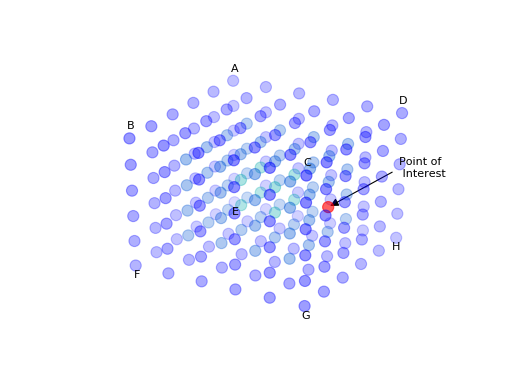

In [112]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys
import os
import copy
from itertools import combinations
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import matplotlib.colors as mpclr
import matplotlib.cm as cm
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

sys.path.append('../')
sys.path.append('../paretoviz')
from paretoviz import plotting as pplt
from paretoviz import decorator as dcor
from paretoviz.utils import fmt
from paretoviz.utils import vectorops as vops

# we might need to draw arrows.
class Arrow3D(FancyArrowPatch):
    """
    The 3d arrow class
    """
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def get_layers(pts, L):
    """
    Peel the cube into layers, we need this for coloring
    each layer differently.
    """
    layers = []
    rest = set([i for i in range(len(pts))])
    for l in range(L):
        layer = []
        for i in rest:
            if pts[i][0] == l or pts[i][0] == L - (l + 1) \
                or pts[i][1] == l or pts[i][1] == L - (l + 1) \
                    or pts[i][2] == l or pts[i][2] == L - (l + 1):
                        layer.append(i)
        if len(layer) > 0:
            rest = rest - set(layer)
            layers.append(layer)
    return layers

def cube(L = 6, s = 100.0, cmap = cm.get_cmap('winter'), alpha = 1.0):
    """
    This function makes a cube of size L^3
    """
    # the length should always be even
    if L % 2 != 0:
        L = L + 1
    # generate L^3 points
    pts = []
    for x in range(0, L):
        for y in range(0, L):
            for z in range(0, L):
                pts.append([x, y, z])
    # now separate the points into layer
    layers = get_layers(pts, L)
    # use this color map for each layer
    clrs = [cmap(1.0 / len(layers) * d) for i,d in enumerate(range(len(layers)))]
    c = [None] * len(pts)
    for li,layer in enumerate(layers):
        for i in layer:
            lst = list(clrs[li])
            lst[-1] = alpha
            c[i] = tuple(lst)
    # return points, size, color and layer indices
    return (pts, [s] * len(pts), c, layers)

path = "../data/cube"
prefix = "cube"
        
L = 6
s = 100
alpha = 0.50

pts, sz, clr, layers = cube(L, s = s, alpha = alpha)
for i in range(len(clr)):
    if pts[i][0] == 4 and pts[i][1] == 3 and pts[i][2] == 2:
        clr[i] = mpclr.to_rgba('r', alpha = 1.0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_axis_off()

[x, y, z] = list(zip(*pts))
ax.scatter(x, y, z, s = s, c = clr)

ax.text(5, 5, 2.5, "Point of\n Interest")
a = Arrow3D([4.9, 4], [4.9, 3], [2.75, 2], mutation_scale = 15, \
                lw = 1, arrowstyle = "-|>", color = "black")
ax.add_artist(a)

delta = 0.2
ax.text(0 - delta,     (L-1) + delta, (L-1) + delta, "A")
ax.text(0 - delta,     0 + delta,     (L-1) + delta, "B")
ax.text((L-1) - delta, 0 + delta,     (L-1) + delta, "C")
ax.text((L-1) - delta, (L-1) + delta, (L-1) + delta, "D")
#
ax.text(0 - delta,     (L-1) + delta, -0.5 - delta, "E")
ax.text(0 - delta,     0 + delta,     -0.5 - delta, "F")
ax.text((L-1) - delta, 0 + delta,     -0.5 - delta, "G")
ax.text((L-1) - delta, (L-1) + delta, -0.5 - delta, "H")

# save the scatter plot
fpath = os.path.join(path, prefix + "-scatter.pdf")
plt.savefig(fpath, transparent = False)

plt.show()

<IPython.core.display.Javascript object>


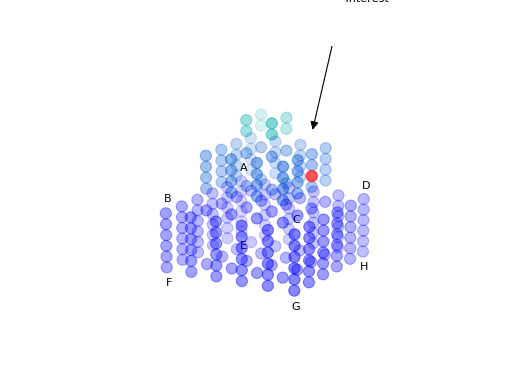

In [113]:
def shift(pts, layer, delta = [0, 0, 0]):
    pts_ = []
    for i in layer:
        pts_.append([pts[i][0] + delta[0], \
                    pts[i][1] + delta[1], \
                    pts[i][2] + delta[2]])
    return pts_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev = 15, azim = -60)
ax.set_aspect('equal')
# plt.axis('scaled')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_axis_off()

[x, y, z] = list(zip(*[pts[i] for i in layers[0]]))
ax.scatter(x, y, z, s = s, c = [clr[i] for i in layers[0]])

pts_ = shift(pts, layers[1], delta = [0, 0, 6])
[x, y, z] = list(zip(*pts_))
ax.scatter(x, y, z, s = s, c = [clr[i] for i in layers[1]])

pts_ = shift(pts, layers[2], delta = [0, 0, 10])
[x, y, z] = list(zip(*pts_))
ax.scatter(x, y, z, s = s, c = [clr[i] for i in layers[2]])

delta = 0.2
ax.text(0 - delta, 5 + delta, 5 + 4 * delta, "A")
ax.text(0 - delta, 0 + delta, 5 + 4 * delta, "B")
ax.text(5 - delta, 0 + delta, 5 + 4 * delta, "C")
ax.text(5 - delta, 5 + delta, 5 + 4 * delta, "D")
#
ax.text(0 - delta, 5 + delta, 0 - (10 * delta), "E")
ax.text(0 - delta, 0 + delta, 0 - (10 * delta), "F")
ax.text(5 - delta, 0 + delta, 0 - (10 * delta), "G")
ax.text(5 - delta, 5 + delta, 0 - (10 * delta), "H")

ax.text(5.4, 2.4, 24, "Point of\n Interest")
a = Arrow3D([5.4, 4], [2.4, 3], [24, 12], mutation_scale = 15, \
                lw = 1, arrowstyle = "-|>", color = "black")
ax.add_artist(a)

# save the scatter plot
fpath = os.path.join(path, prefix + "-peeling.pdf")
plt.savefig(fpath, transparent = False)

plt.show()


<IPython.core.display.Javascript object>


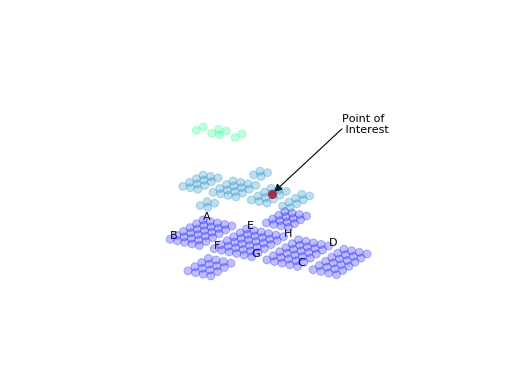

In [114]:
def peeledcube(L = 6, z = 0):
    pts = []
    for x in range(0, L):
        for y in range(0, L):
            pts.append([x, y, z])
            
    for x in range(L + 1, 2 * L):
        for y in range(0, L):
            pts.append([x, y, z])
            
    for x in range(2 * L + 1, (3 * L) - 1):
        for y in range(0, L):
            pts.append([x, y, z])
            
    for x in range(-2, - 1 - L, -1):
        for y in range(0, L):
            pts.append([x, y, z])
            
    for x in range(1, L - 1):
        for y in range(-2, -L, -1):
            pts.append([x, y, z])
            
    for x in range(1, L - 1):
        for y in range(L + 1, 2 * L - 1):
            pts.append([x, y, z])
    return pts

alpha = 0.25
cmap = cm.get_cmap('winter')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_axis_off()

pts_ = peeledcube(6, z = 0)
[x, y, z] = list(zip(*pts_))
ax.scatter(x, y, z, s = s * 0.5, c = [cmap(0.0)] * len(pts_), alpha = alpha)

pts_ = peeledcube(4, z = 1)
[x, y, z] = list(zip(*pts_))
ax.scatter(x, y, z, s = s * 0.5, c = [cmap(0.5)] * len(pts_), alpha = alpha)
ax.scatter(6, 2, 1, s = s * 0.5, c = 'red', alpha = 1.0)

pts_ = peeledcube(2, z = 2)
[x, y, z] = list(zip(*pts_))
ax.scatter(x, y, z, s = s * 0.5, c = [cmap(1.0)] * len(pts_), alpha = alpha)

ax.text(10, 8, 1.75, "Point of\n Interest")
a = Arrow3D([10.1, 6], [8.1, 2], [1.85, 1], mutation_scale = 15, \
                lw = 1, arrowstyle = "-|>", color = "black")
ax.add_artist(a)

ax.text(-L, L-1, 0, "A")
ax.text(-L, 0, 0, "B")
ax.text(L + (L-1), 0, 0, "C")
ax.text(L + (L-1), L-1, 0, "D")
ax.text(0, L-1, 0, "E")
ax.text(0, 0, 0, "F")
ax.text(L-1, 0, 0, "G")
ax.text(L-1, L-1, 0, "H")

# save the scatter plot
fpath = os.path.join(path, prefix + "-flattening.pdf")
plt.savefig(fpath, transparent = False)


plt.show()

<IPython.core.display.Javascript object>


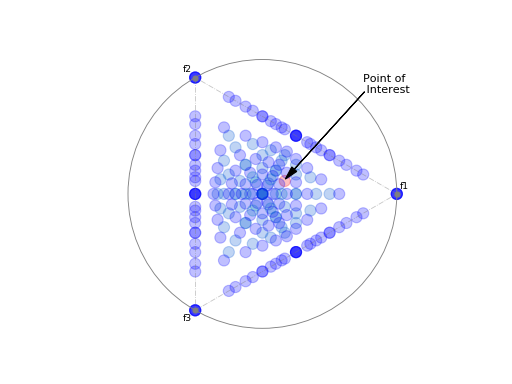

In [115]:
# Do the radviz plot
(fig, ax) = pplt.radviz(pts, s = sz, c = clr, alpha = alpha)

ax.text(0.75, 0.75, "Point of\n Interest")
plt.arrow(0.76, 0.76, -0.59, -0.65, lw = 1, color = "black", \
          length_includes_head = True, head_length = 0.1, head_width = 0.05)

# save the radviz plot
fpath = os.path.join(path, prefix + "-radviz.pdf")
plt.savefig(fpath, transparent = False)

plt.show()

<IPython.core.display.Javascript object>


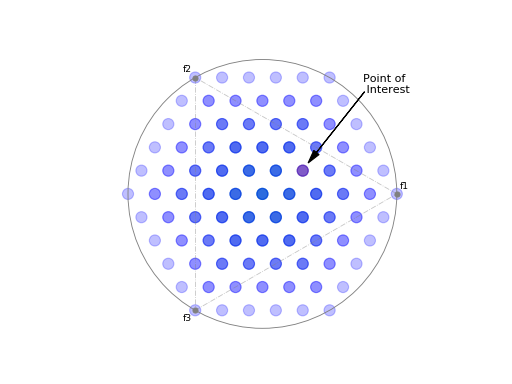

In [116]:
# Do the radviz plot
(fig, ax) = pplt.star(pts, s = sz, c = clr, alpha = alpha)

ax.text(0.75, 0.75, "Point of\n Interest")
plt.arrow(0.76, 0.76, -0.42, -0.53, lw = 1, color = "black", \
          length_includes_head = True, head_length = 0.1, head_width = 0.05)

# save the radviz plot
fpath = os.path.join(path, prefix + "-star.pdf")
plt.savefig(fpath, transparent = False)

plt.show()

<IPython.core.display.Javascript object>


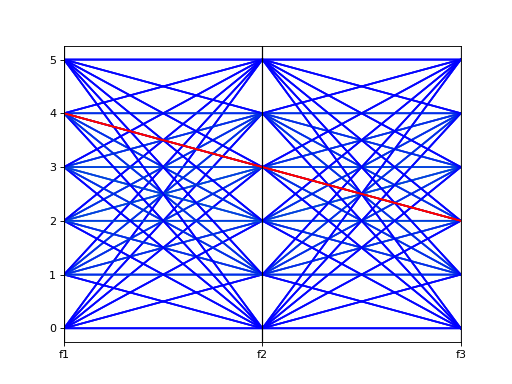

In [117]:
import numpy as np
import pandas as pd

def pcp(X, title = "", show_legend = False, color = None, label = "f{:d}"):
    df = pd.DataFrame(X, columns = [label.format(i+1) for i in range(X.shape[1])])
    df['X'] = ['X_%s' % i for i in range(X.shape[0])]
    if color is None:
        ax = pd.plotting.parallel_coordinates(df, 'X')
        ax.grid(False)
    else:
        ax = pd.plotting.parallel_coordinates(df, 'X', color = color)
        ax.grid(False)
    if not show_legend:
        plt.gca().legend_.remove()
    plt.title(title)

F = np.array(pts)
plt.figure()
pcp(F, "", color = clr)
pcp(np.array([[4, 3, 2], [4, 3, 2]]), "", color = 'r')

# save the radviz plot
fpath = os.path.join(path, prefix + "-pcp.pdf")
plt.savefig(fpath, transparent = False)

plt.show()

<IPython.core.display.Javascript object>


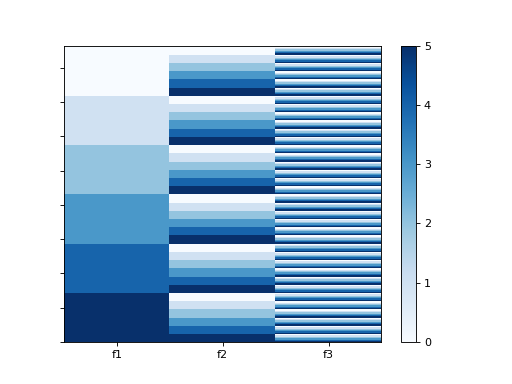

In [118]:
import numpy as np
import pandas as pd

xtickl = ["f{0:d}".format(i+1) for i in range(len(pts[0]))]

points_ = sorted(pts, reverse = True)
data = np.array(points_)
df = pd.DataFrame(data = data[0:,0:], \
                  index = np.arange(len(pts)), \
                  columns = np.arange(len(pts[0])))

fig = plt.figure()
ax = plt.gca()
ax.set_yticklabels([])
c = ax.pcolor(df, cmap = 'Blues')
plt.xticks(np.arange(0.5, len(xtickl), 1), xtickl)
fig.colorbar(c, ax = ax)

# save the radviz plot
fpath = os.path.join(path, prefix + "-heatmap.pdf")
plt.savefig(fpath, transparent = False)

plt.show()

<IPython.core.display.Javascript object>


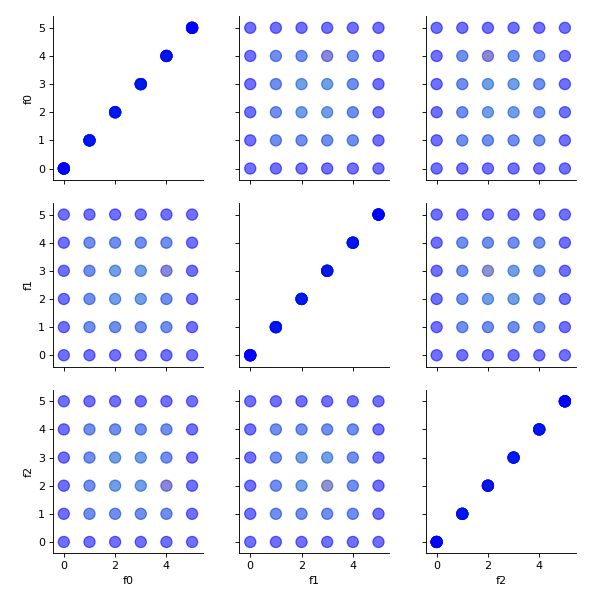

In [119]:
# Do a scatter plot matrix, using seaborn because it can auto-adjust the figsize

import numpy as np
import pandas as pd
import seaborn as sns

data = np.array(pts)
df = pd.DataFrame(data = data[0:,0:], index = np.arange(len(pts)), \
                  columns = np.array(["f{0:d}".format(i) for i in range(len(pts[0]))]))

g = sns.PairGrid(df)
g.map(plt.scatter, s = sz, alpha = alpha * 0.5, color = clr)

# save the radviz plot
fpath = os.path.join(path, prefix + "-spmatrix.pdf")
plt.savefig(fpath, transparent = False)

plt.show()

In [60]:
s = [i for i in range(0,3)]
print(s)

for i in [1, 2, 3]:
    print(i)
    
comb = combinations([1, 2, 3], 3)
for c in comb:
    print(c)

[0, 1, 2]
1
2
3
(1, 2, 3)
